## Distance calculation
This code implements an emotion analysis system using word embeddings and a pre-defined emotion lexicon. The EmotionDistanceCalculator class calculates the emotional similarity between input words and words in an emotion lexicon by computing cosine similarities between their embeddings (generated using DistilBERT). It includes features for similarity score calibration, batch processing, and caching of word embeddings. The system can map words to eight distinct emotions (anger, anticipation, disgust, fear, joy, sadness, surprise, trust) plus neutral, using various calibration methods (exponential, sigmoid, power, minmax) to adjust similarity scores.


In [6]:
import numpy as np
from scipy.spatial.distance import cosine
from transformers import pipeline
from tqdm import tqdm
import pandas as pd


def _compute_similarity(emb1, emb2):
    """Safely compute cosine similarity between two embeddings."""
    try:
        # Ensure vectors are 1D
        emb1 = emb1.flatten()
        emb2 = emb2.flatten()
        return 1 - cosine(emb1, emb2)
    except Exception as e:
        print(f"Error computing similarity: {e}")
        return 0.0


class EmotionDistanceCalculator:
    def __init__(self, emotion_lexicon, device="mps", min_similarity=0,
                 batch_size=32,
                 calibration_method='exponential', 
                 temperature=10.0):
        self.emotion_lexicon = emotion_lexicon
        self.device = device
        self.min_similarity = min_similarity
        self.batch_size = batch_size
        self.calibration_method = calibration_method
        self.temperature = temperature
        self.emotions = ['anger', 'anticipation', 'disgust', 'fear',
                         'joy', 'sadness', 'surprise', 'trust', 'neutral']

        self._normalize_lexicon()
        self.embedder = pipeline("feature-extraction",
                                 model="distilbert-base-uncased",
                                 device=device)
        self.word_embeddings = {}
        self._cache_lexicon_embeddings()

    def _calibrate_similarity(self, similarity, method='exponential'):
        """
        Calibrate similarity scores using different methods.
        """
        if method == 'exponential':
            # Exponential scaling makes high similarities more pronounced
            return np.exp(self.temperature * (similarity - 1))

        elif method == 'sigmoid':
            # Sigmoid transformation with adjusted midpoint
            x = self.temperature * (similarity - 0.95)  # Adjust midpoint
            return 1 / (1 + np.exp(-x))

        elif method == 'power':
            # Power transformation emphasizes differences
            return similarity ** self.temperature

        elif method == 'minmax':
            # MinMax scaling based on observed similarities
            if not hasattr(self, '_sim_min'):
                self._sim_min = 0.85  # Typical minimum similarity
            if not hasattr(self, '_sim_range'):
                self._sim_range = 0.15  # Typical range
            return (similarity - self._sim_min) / self._sim_range

        return similarity

    def _get_embedding(self, text):
        """Safely get embedding for a single text."""
        try:
            emb = self.embedder(text)
            return np.mean(emb[0], axis=0).flatten()
        except Exception as e:
            print(f"Error getting embedding for '{text}': {e}")
            return np.zeros(768)

    def process_single_word(self, input_word):
        """Process a single word with calibrated similarities."""
        target_emb = self._get_embedding(input_word)

        results = {
            'distances'       : {emotion: float('inf') for emotion in
                                 self.emotions},
            'similarities'    : {emotion: -float('inf') for emotion in
                                 self.emotions},
            'nearest_words'   : {emotion: None for emotion in self.emotions},
            'raw_similarities': {emotion: -float('inf') for emotion in
                                 self.emotions}
        }

        best_matches = []

        # First pass: collect all similarities
        all_similarities = []
        for lex_word, word_emotions in self.emotion_lexicon.items():
            if lex_word not in self.word_embeddings:
                continue

            lex_emb = self.word_embeddings[lex_word]
            raw_similarity = 1 - cosine(target_emb.flatten(),
                                        lex_emb.flatten())
            all_similarities.append(raw_similarity)

            similarity = self._calibrate_similarity(raw_similarity,
                                                    self.calibration_method)
            best_matches.append((lex_word, raw_similarity, similarity))

            if similarity >= self.min_similarity:
                for emotion in word_emotions:
                    if emotion in self.emotions and similarity > \
                            results['similarities'][emotion]:
                        results['distances'][emotion] = 1 - similarity
                        results['similarities'][emotion] = similarity
                        results['raw_similarities'][emotion] = raw_similarity
                        results['nearest_words'][emotion] = lex_word


        # Convert infinities to NaN
        results['distances'] = {k: np.nan if v == float('inf') else v
                                for k, v in results['distances'].items()}
        results['similarities'] = {k: np.nan if v == -float('inf') else v
                                   for k, v in results['similarities'].items()}

        return {input_word: results}

    def _normalize_lexicon(self):
        """Ensure all emotions in lexicon are lists."""
        normalized_lexicon = {}
        for word, emotions in self.emotion_lexicon.items():
            if isinstance(emotions, str):
                normalized_lexicon[word] = [emotions]
            elif isinstance(emotions, list):
                normalized_lexicon[word] = emotions
            else:
                normalized_lexicon[word] = [str(emotions)]
        self.emotion_lexicon = normalized_lexicon

    def _cache_lexicon_embeddings(self):
        """Cache embeddings with verification."""
        print("Starting lexicon embedding cache...")
        self.lexicon_words = list(self.emotion_lexicon.keys())

        for i in tqdm(range(0, len(self.lexicon_words), self.batch_size)):
            batch = self.lexicon_words[i:i + self.batch_size]
            for word in batch:
                self.word_embeddings[word] = self._get_embedding(word)

        print(f"Cached embeddings for {len(self.word_embeddings)} words")

    def process_batch(self, target_words):
        """Process multiple words."""
        print("Processing words...")
        results = {}
        for word in tqdm(target_words):
            result = self.process_single_word(word)
            results.update(result)
        return results




## Load the lexicon and CMV

In [7]:
from nrclex import NRCLex

feelings_nrc = NRCLex("/Users/Panos/Library/CloudStorage/Dropbox/PI_Squared"
                      "/PycharmProjects/Research/NRCLex/nrc_v3.json")

emotion_lexicon = feelings_nrc.__lexicon__

In [18]:
from convokit import Corpus

corpus = Corpus("/Users/Panos/.convokit/downloads/winning-args-corpus")


def get_thread(corpus: Corpus, conv_id: str) -> pd.DataFrame:
    """
    Extracts and structures conversation data from a ConvoKit corpus for a given conversation ID.
    
    Args:
        corpus (Corpus): The ConvoKit corpus containing conversation data.
        conv_id (str): The conversation ID for which to extract the thread.
    
    Returns:
        pd.DataFrame: A DataFrame containing utterance ID, speaker, reply-to relationship, timestamp, and text for the conversation thread.
    """
    root_conversation = corpus.conversations[conv_id]

    # Loop through each utterance and collect necessary information
    thread_data = []
    for utt in root_conversation.iter_utterances():
        try:
            thread_data.append({
                'utterance_id': utt.id,
                'speaker'     : utt.speaker.id,
                'reply_to'    : utt.reply_to if utt.reply_to is not None
                else utt.id,
                'timestamp'   : utt.timestamp if utt.timestamp is not None
                else 0,
                'text'        : utt.text,
                'success'     : utt.meta['success'] if utt.meta['success']
                                                       is not None else -1
            })
        except KeyError:
            continue

    # Create a DataFrame from the collected data and sort it
    df = pd.DataFrame(thread_data)
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    return df


# Get conversation IDs
convos = [i.id for i in corpus.iter_conversations()]

# Extract thread data for the first conversation
thread_df = get_thread(corpus, convos[0])
text = thread_df["text"][0]

## Initialize the calcuator

In [9]:
calculator = EmotionDistanceCalculator(emotion_lexicon, batch_size=32)

Starting lexicon embedding cache...


100%|██████████| 143/143 [00:33<00:00,  4.25it/s]

Cached embeddings for 4566 words


## Simple test

In [21]:
# Process words
words_to_analyze = ['angry', 'happily', 'sadly', 'excitedly', 'nervously']
results = calculator.process_batch(words_to_analyze)

# Print results for a word
word = 'angry'
for word in words_to_analyze:
    print(f"\nSimilarities for '{word}':")
    for emotion, sim in results[word]['similarities'].items():
        if not np.isnan(sim):
            nearest = results[word]['nearest_words'][emotion]
            print(f"{emotion}: {sim:.3f} (nearest: {nearest})")

Processing words...


100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Similarities for 'angry':
anger: 1.000 (nearest: angry)
anticipation: 0.438 (nearest: revenge)
disgust: 1.000 (nearest: angry)
fear: 0.530 (nearest: violent)
joy: 0.398 (nearest: passionate)
sadness: 0.529 (nearest: fury)
surprise: 0.530 (nearest: violent)
trust: 0.392 (nearest: proud)
neutral: 0.454 (nearest: upset)

Similarities for 'happily':
anger: 0.518 (nearest: miserable)
anticipation: 0.638 (nearest: delighted)
disgust: 0.538 (nearest: pathetic)
fear: 0.510 (nearest: hysterical)
joy: 1.000 (nearest: happily)
sadness: 0.560 (nearest: unhappy)
surprise: 0.638 (nearest: delighted)
trust: 0.538 (nearest: happy)
neutral: 0.528 (nearest: terribly)

Similarities for 'sadly':
anger: 0.532 (nearest: disappointed)
anticipation: 0.492 (nearest: glad)
disgust: 0.532 (nearest: disappointed)
fear: 0.506 (nearest: sorrow)
joy: 0.492 (nearest: glad)
sadness: 1.000 (nearest: sadly)
surprise: 0.440 (nearest: surprisingly)
trust: 0.411 (nearest: thoughtful)
neutral: 0.514 (nearest: terribly)

Si

## Helper functions - Statistics

This code implements a comprehensive analysis and visualization framework for emotion detection results. It takes the output from the previously defined EmotionDistanceCalculator and processes it in several ways:

- The analyze_emotion_distances function converts the raw emotion detection 
results into a structured pandas DataFrame, organizing word-emotion pairs with their similarity scores and nearest matching words.
- calculate_emotion_statistics computes descriptive statistics (mean, 
 standard deviation, quartiles, etc.) for each emotion category's similarity scores.
- plot_emotion_analysis creates visualization plots using Seaborn and 
Matplotlib, generating histograms for the distribution of similarity scores across different emotions in a grid layout.
- get_top_matches and print_emotion_analysis provide detailed reporting 
functionality, showing the top matching words for each emotion and printing comprehensive statistics.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def analyze_emotion_distances(emotion_distances_results):
    """
    Analyze emotion distances for any input text.
    
    Args:
        emotion_distances_results: Dictionary of results from EmotionDistanceCalculator
        
    Returns:
        DataFrame with statistics for each emotion
    """
    # Collect all distances per emotion
    all_stats = []
    
    for word, word_results in emotion_distances_results.items():
        for emotion, similarity in word_results['similarities'].items():
            if not np.isnan(similarity):
                all_stats.append({
                    'word': word,
                    'emotion': emotion,
                    'similarity': similarity,
                    'nearest_word': word_results['nearest_words'][emotion]
                })
    
    return pd.DataFrame(all_stats)

def calculate_emotion_statistics(results_df):
    """
    Calculate statistics for each emotion.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        
    Returns:
        Dictionary of statistics per emotion
    """
    stats = {}
    
    for emotion in results_df['emotion'].unique():
        emotion_data = results_df[results_df['emotion'] == emotion]['similarity']
        
        stats[emotion] = {
            'count': len(emotion_data),
            'mean': emotion_data.mean(),
            'std': emotion_data.std(),
            'min': emotion_data.min(),
            'max': emotion_data.max(),
            'median': emotion_data.median(),
            'q25': emotion_data.quantile(0.25),
            'q75': emotion_data.quantile(0.75)
        }
    
    return stats

def plot_emotion_analysis(results_df):
    """
    Create various plots for emotion analysis.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        
    Returns:
        Dictionary of figures
    """
    figures = {}
    
    # Histogram grid for each emotion
    n_emotions = len(results_df['emotion'].unique())
    n_cols = 3
    n_rows = (n_emotions + n_cols - 1) // n_cols
    
    fig_hist, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    axes = axes.flatten()
    
    for idx, emotion in enumerate(sorted(results_df['emotion'].unique())):
        emotion_data = results_df[results_df['emotion'] == emotion]
        sns.histplot(data=emotion_data, x='similarity', bins=30, ax=axes[idx])
        axes[idx].set_title(f'{emotion} Distribution')
        
    # Hide empty subplots
    for idx in range(n_emotions, len(axes)):
        axes[idx].set_visible(False)
        
    plt.tight_layout()
    figures['histograms'] = fig_hist
    
    return figures

def get_top_matches(results_df, n=10):
    """
    Get top N matches for each emotion.
    
    Args:
        results_df: DataFrame from analyze_emotion_distances
        n: Number of top matches to return
        
    Returns:
        Dictionary of top matches per emotion
    """
    top_matches = {}
    
    for emotion in results_df['emotion'].unique():
        emotion_data = results_df[results_df['emotion'] == emotion].nlargest(n, 'similarity')
        top_matches[emotion] = emotion_data[['word', 'similarity', 'nearest_word']].to_dict('records')
    
    return top_matches

def print_emotion_analysis(stats, top_matches):
    """
    Print detailed analysis results.
    
    Args:
        stats: Dictionary from calculate_emotion_statistics
        top_matches: Dictionary from get_top_matches
    """
    print("\nEmotion Statistics:")
    print("-" * 50)
    
    for emotion, stat in stats.items():
        print(f"\n{emotion.upper()}:")
        print(f"Count: {stat['count']}")
        print(f"Mean: {stat['mean']:.3f} (±{stat['std']:.3f})")
        print(f"Range: [{stat['min']:.3f}, {stat['max']:.3f}]")
        print(f"Quartiles: {stat['q25']:.3f} | {stat['median']:.3f} | {stat['q75']:.3f}")
        
        print("\nTop matches:")
        for idx, match in enumerate(top_matches[emotion][:5], 1):
            print(f"{idx}. {match['word']} -> {match['nearest_word']} ({match['similarity']:.3f})")

## Lexicon expansions of itself, statistics

Processing words...


100%|██████████| 4566/4566 [02:30<00:00, 30.31it/s]



Emotion Statistics:
--------------------------------------------------

ANGER:
Count: 4566
Mean: 0.535 (±0.283)
Range: [0.061, 1.000]
Quartiles: 0.290 | 0.476 | 0.708

Top matches:
1. abhor -> abhor (1.000)
2. abhorrent -> abhorrent (1.000)
3. abomination -> abomination (1.000)
4. abuse -> abuse (1.000)
5. accusation -> accusation (1.000)

ANTICIPATION:
Count: 4566
Mean: 0.464 (±0.260)
Range: [0.057, 1.000]
Quartiles: 0.230 | 0.445 | 0.613

Top matches:
1. accelerate -> accelerate (1.000)
2. accolade -> accolade (1.000)
3. accompaniment -> accompaniment (1.000)
4. achievement -> achievement (1.000)
5. acquire -> acquire (1.000)

DISGUST:
Count: 4566
Mean: 0.536 (±0.278)
Range: [0.070, 1.000]
Quartiles: 0.307 | 0.479 | 0.704

Top matches:
1. aberration -> aberration (1.000)
2. abhor -> abhor (1.000)
3. abhorrent -> abhorrent (1.000)
4. abject -> abject (1.000)
5. abnormal -> abnormal (1.000)

FEAR:
Count: 4566
Mean: 0.538 (±0.284)
Range: [0.071, 1.000]
Quartiles: 0.291 | 0.480 | 0.715


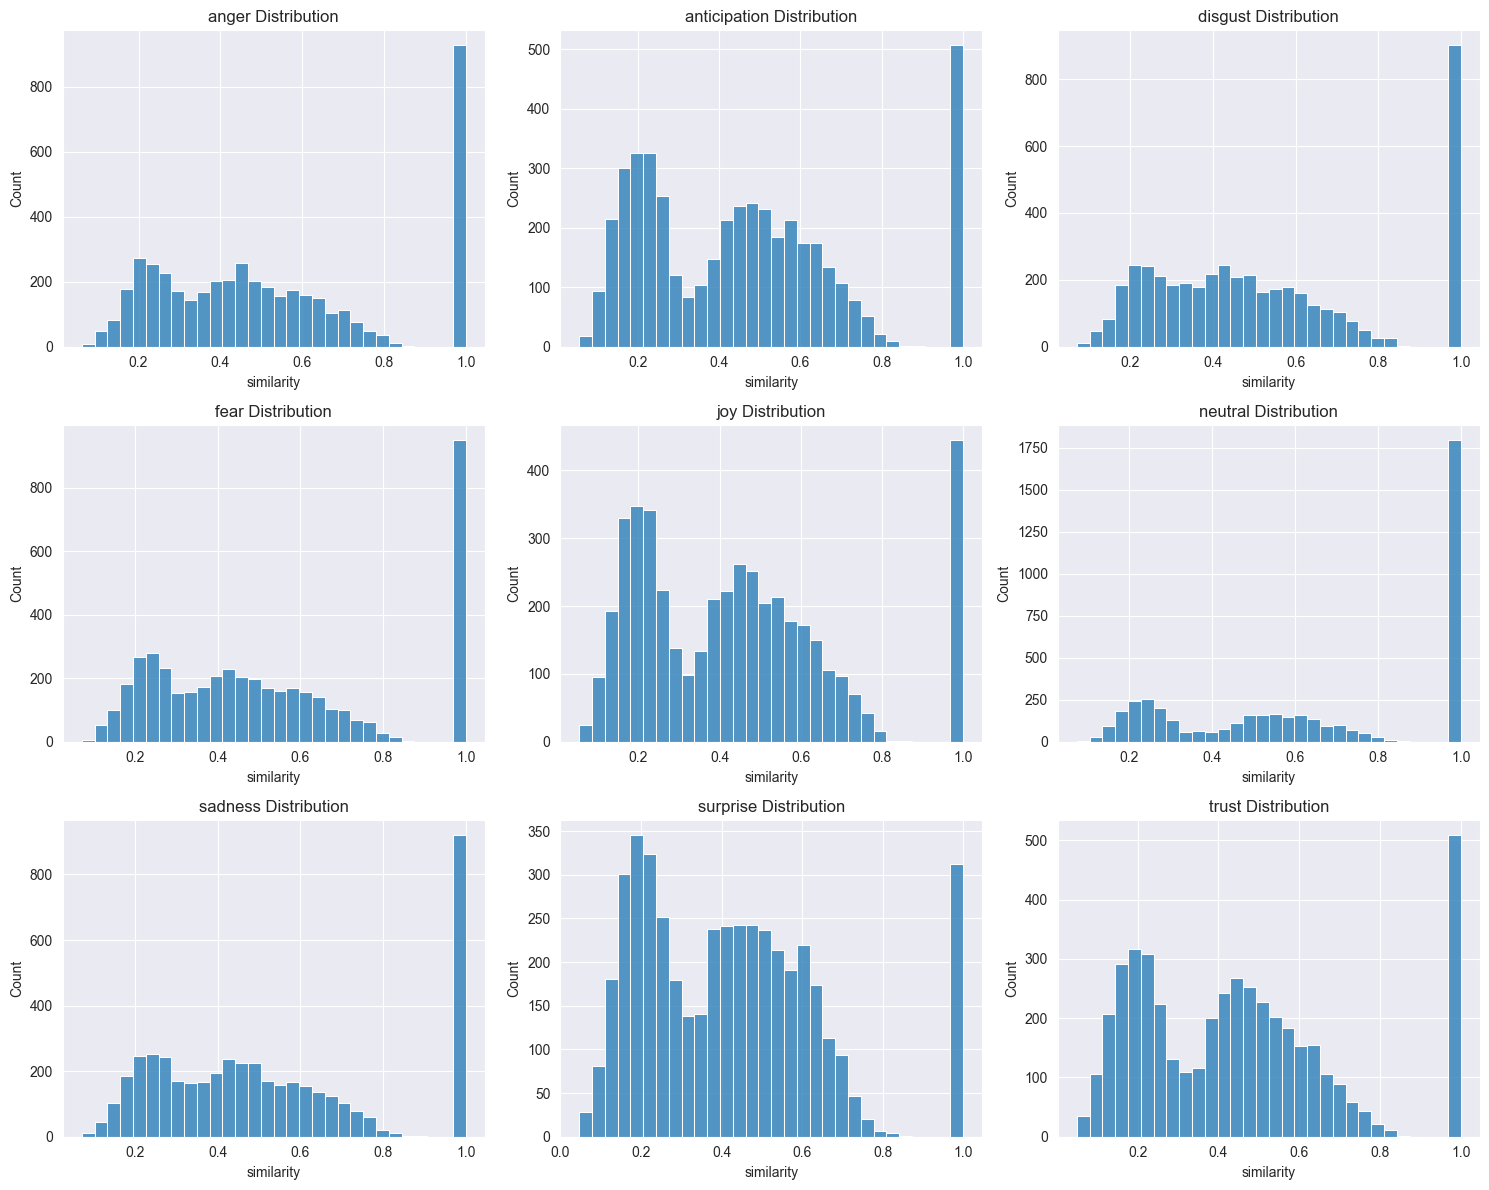

anger: mean=0.535, std=0.283
anticipation: mean=0.464, std=0.260
disgust: mean=0.536, std=0.278
fear: mean=0.538, std=0.284
joy: mean=0.444, std=0.251
sadness: mean=0.537, std=0.280
surprise: mean=0.424, std=0.232
trust: mean=0.453, std=0.260
neutral: mean=0.653, std=0.316


In [14]:
results = calculator.process_batch(list(emotion_lexicon.keys()))

# Results from EmotionDistanceCalculator
results_df = analyze_emotion_distances(results)

# Calculate statistics
stats = calculate_emotion_statistics(results_df)

# Get top matches
top_matches = get_top_matches(results_df)

# Print analysis
print_emotion_analysis(stats, top_matches)

# Create plots
figures = plot_emotion_analysis(results_df)
plt.show()

# Access specific statistics
for emotion, stat in stats.items():
    print(f"{emotion}: mean={stat['mean']:.3f}, std={stat['std']:.3f}")

## Lexicon expansion statistics - CMV 

Processing words...


100%|██████████| 264/264 [00:09<00:00, 26.52it/s]



Emotion Statistics:
--------------------------------------------------

ANGER:
Count: 156
Mean: 0.395 (±0.168)
Range: [0.015, 1.000]
Quartiles: 0.316 | 0.391 | 0.452

Top matches:
1. disagree -> disagree (1.000)
2. opposed -> opposed (1.000)
3. argument -> argument (1.000)
4. spurred -> restrain (0.818)
5. arguments -> argument (0.798)

ANTICIPATION:
Count: 156
Mean: 0.411 (±0.162)
Range: [0.014, 1.000]
Quartiles: 0.336 | 0.425 | 0.480

Top matches:
1. coming -> coming (1.000)
2. think -> think (1.000)
3. intended -> intended (1.000)
4. spurred -> withstand (0.770)
5. disagree -> withstand (0.760)

DISGUST:
Count: 156
Mean: 0.377 (±0.146)
Range: [0.015, 1.000]
Quartiles: 0.311 | 0.383 | 0.441

Top matches:
1. unnatural -> unnatural (1.000)
2. disagree -> contentious (0.805)
3. spurred -> displeasure (0.800)
4. debating -> contentious (0.793)
5. creations -> plight (0.732)

FEAR:
Count: 156
Mean: 0.388 (±0.151)
Range: [0.015, 1.000]
Quartiles: 0.323 | 0.388 | 0.454

Top matches:
1. opp

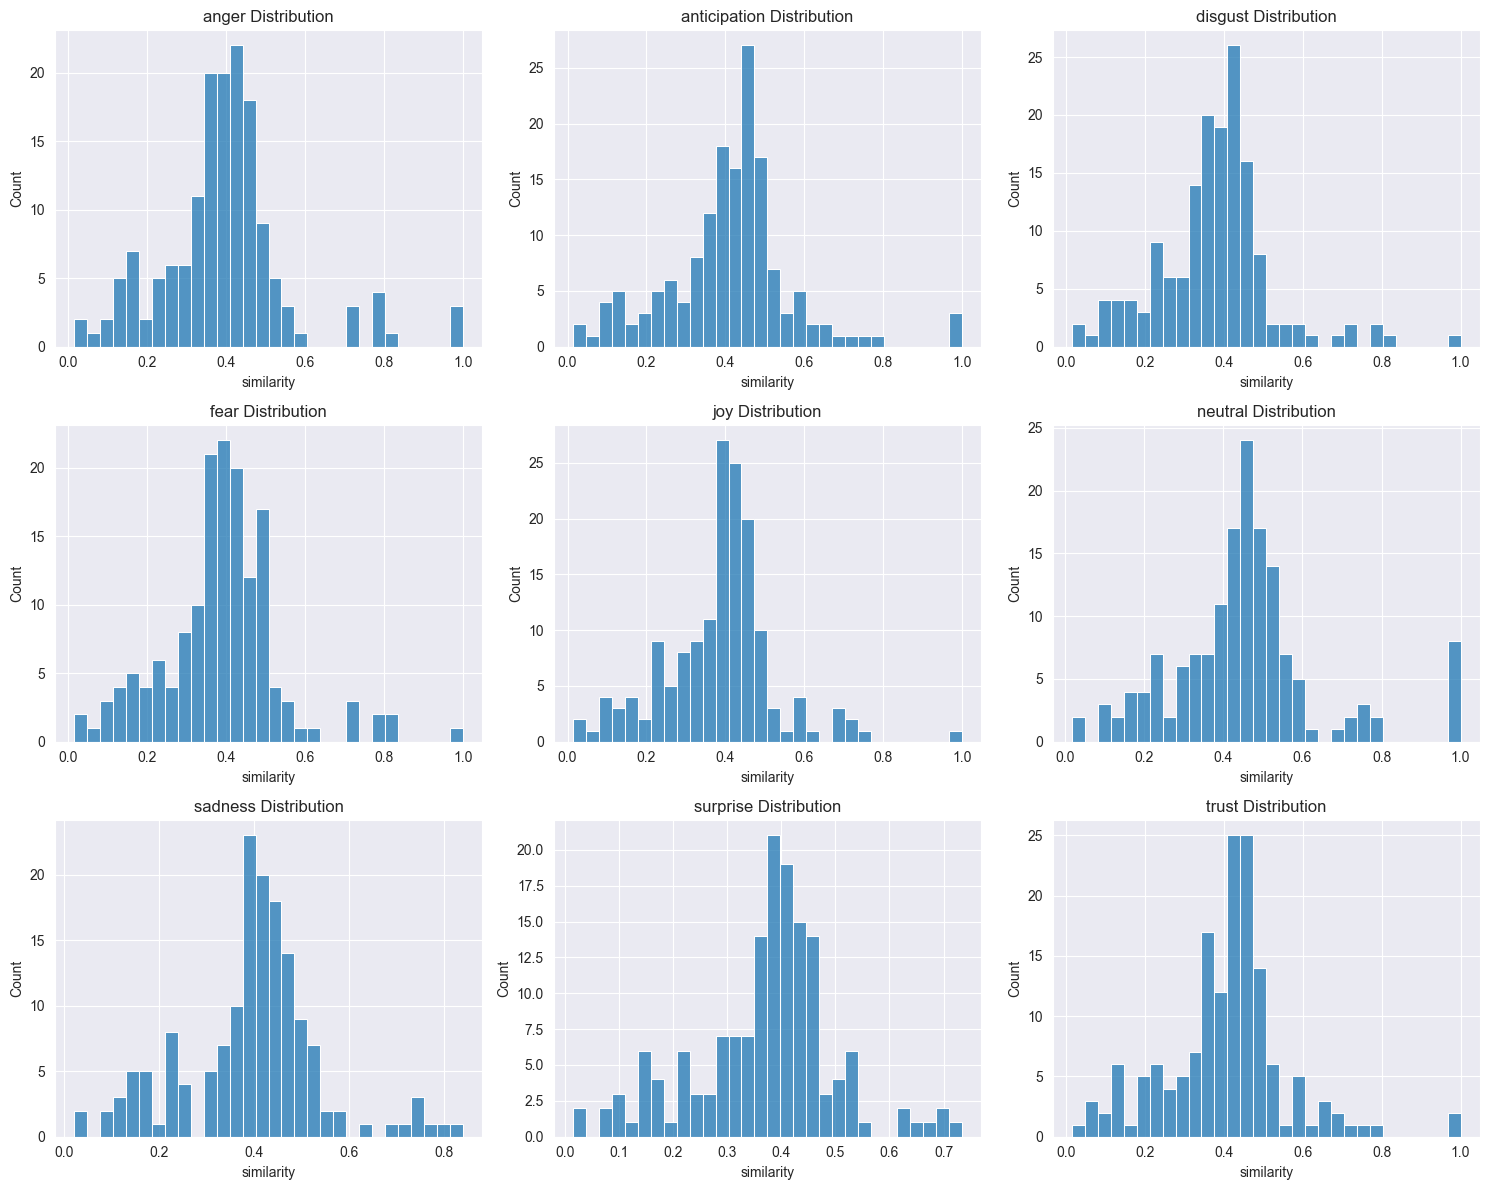

anger: mean=0.395, std=0.168
anticipation: mean=0.411, std=0.162
disgust: mean=0.377, std=0.146
fear: mean=0.388, std=0.151
joy: mean=0.386, std=0.142
sadness: mean=0.396, std=0.144
surprise: mean=0.369, std=0.130
trust: mean=0.405, std=0.157
neutral: mean=0.453, std=0.193


In [20]:
results = calculator.process_batch(text.split(" "))

# Results from EmotionDistanceCalculator
results_df = analyze_emotion_distances(results)

# Calculate statistics
stats = calculate_emotion_statistics(results_df)

# Get top matches
top_matches = get_top_matches(results_df)

# Print analysis
print_emotion_analysis(stats, top_matches)

# Create plots
figures = plot_emotion_analysis(results_df)
plt.show()

# Access specific statistics
for emotion, stat in stats.items():
    print(f"{emotion}: mean={stat['mean']:.3f}, std={stat['std']:.3f}")

## Example usage

In [31]:
# This loads the calculation class. It caches the lexicon vectors so it takes 
# some time. 
calculator = EmotionDistanceCalculator(emotion_lexicon, batch_size=128)

# Process words
results = calculator.process_batch(text.split(" "))

# Get results. In our case the most simple way to use at the moment is to 
# get the similarities of the emotions to the lexicon.
print(results["unnatural"]["similarities"])

Starting lexicon embedding cache...


100%|██████████| 36/36 [00:35<00:00,  1.03it/s]


Cached embeddings for 4566 words
Processing words...


100%|██████████| 264/264 [00:08<00:00, 30.56it/s]

{'anger': 0.7349355114060421, 'anticipation': 0.6828271570997521, 'disgust': 1.0, 'fear': 0.7349355114060421, 'joy': 0.697844518489623, 'sadness': 0.7349355114060421, 'surprise': 0.7336310931808816, 'trust': 0.697844518489623, 'neutral': 0.7186014046423445}
